2024/08/20

[Reverse-Engineering Neural Networks to Characterize Their Cost Functions (Isomura & Friston, 2020/11)](https://direct.mit.edu/neco/article/32/11/2085/95634/Reverse-Engineering-Neural-Networks-to) で扱われている信号源分離NN(実質尤度行列)のFEPによる学習の[MatLab実装](https://github.com/takuyaisomura/reverse_engineering/tree/master)のPython移植＋PyTorchによる自動微分

- Hidden state $s \in \{0,1\}^{N_s \times 2} \ (N_s = 2)$
  - $s_l^{(j)}$: $j$ 番目の状態が $l=0$ か $l=1$ か (one-hot)
- Observation (model input) $o \in \{0,1\}^{N_o \times 2}$
  - $o_k^{(i)}$: $i$ 番目の観測が $k=0$ か $k=1$ か (one-hot)
- Likelihood $A_{k,l_0,l_1}^{(i)} = P(o_k^{(i)} \mid s_{l_0}^{(0)}, s_{l_1}^{(1)})$
- Posterior expectations (model parameters)
  - Concentration parameters $\mathbf{a} \in (0, \infty)^{N_o \times 2 \times N_s \times 2}$
  - Likelihood $\mathbf{A} = \frac{\mathbf{a}}{\mathbf{a}_{0,:} + \mathbf{a}_{1,:}} \in (0, 1)^{N_o \times 2 \times N_s \times 2}$
  - State $\mathbf{s} = \frac{v}{v_0 + v_1} = \sigma(\ln v) \in (0, 1)^{N_s \times 2}$
    - $v  = \exp\left( \sum_{i,k} \left( \ln \mathbf{A}_{k,:}^{(i,:)} \right) \odot o_k^{(i)} + \alpha \right) \in (0, \infty)^{N_s \times 2}$
- VFE (cost function) $F = \sum_{\tau,j,l} \mathbf{s}_l^{(j)} \ln \frac{\mathbf{s}_l^{(j)}}{v_l^{(j)}}$
  - 勾配(解析解) $\frac{\partial F}{\partial \mathbf{a}_{k,l}^{(i,j)}} = -o_k^{(i)} \mathbf{s}_l^{(j)}$

# 解析解による更新

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Ns = 2      # number of hidden states
No = 32     # number of observations
T = 5000    # time

In [2]:
def cost_function(o, qa, alpha):
    o = o.reshape(-1, No, 2, 1, 1)
    qA = qa / qa.sum(1, keepdims=True)
    v = np.exp((np.log(qA) * o).sum((1, 2)) + alpha)    # (T, Ns, 2)
    qs = v / v.sum(-1, keepdims=True)                   # (T, Ns, 2)
    L = (qs * np.log(qs / v + 1e-24)).sum()
    return L

def mdp_bss(o, qa_init, alpha):
    o = o.reshape(-1, No, 2, 1, 1)
    qs = np.zeros((T,          Ns, 2))
    qA = np.zeros((T+1, No, 2, Ns, 2))
    qa = np.zeros((T+1, No, 2, Ns, 2))
    cost = np.zeros(T)
    qa[0] = qa_init.copy()
    qA[0] = qa[0] / qa[0].sum(1, keepdims=True)
    for t in range(T):
        v = np.exp((np.log(qA[t]) * o[t]).sum((0, 1)) + alpha)  # (Ns, 2)
        qs[t] = v / v.sum(-1, keepdims=True)                    # (Ns, 2)
        cost[t] = cost_function(o[:t+1], qa[t], alpha) / (t+1)
        qa[t+1] = qa[t] + o[t] * qs[t,None,None]
        qA[t+1] = np.clip(qa[t+1] / qa[t+1].sum(1, keepdims=True), 1e-6, 1-1e-6)
    return qs, qA[:T], qa[:T], cost

In [3]:
np.random.seed(9999)

# Generative Process
A = np.zeros((No, 2, 2, 2)) # A[i,k,l0,l1] = P(o_i=k | s_j=l_j)
A[:No//2, 0] = [[1, 3/4], [1/4, 0]]
A[No//2:, 0] = [[1, 1/4], [3/4, 0]]
A[:, 1, :, :] = 1 - A[:, 0, :, :]
s = np.eye(2, dtype=int)[np.random.randint(0, 2, (T, Ns))]  # (T, Ns, 2)
o = np.eye(2, dtype=int)[(np.random.rand(T*No).reshape((T,No)) > A[:, 0, 1-s[:,0,0], 1-s[:,1,0]].T)*1]    # (T, No, 2)

# Initial Connection Strengths
qa_init = np.array([[[.51,.49],[.5,.5]]]*(No//2) + [[[.5,.5],[.49,.51]]]*(No//2))   # (No, Ns, 2)
qa_init = np.stack([qa_init, 1-qa_init], axis=1) * 100

alpha = np.log(np.array([[0.5, 0.5], [0.5, 0.5]]))  # (Ns, 2)
qs, qA, qa, cost = mdp_bss(o, qa_init, alpha)

Text(0, 0.5, 'VFE')

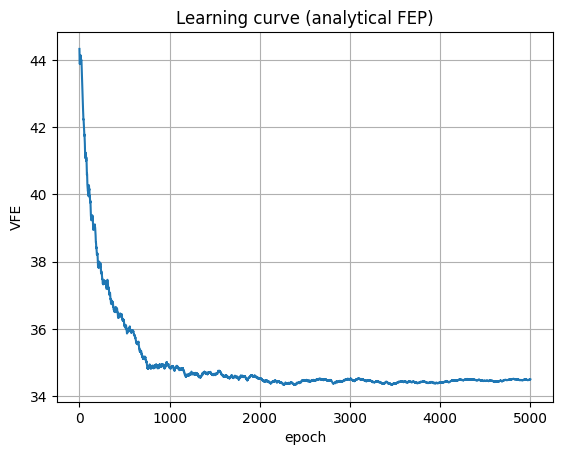

In [4]:
plt.plot(cost)
plt.grid()
plt.title("Learning curve (analytical FEP)")
plt.xlabel("epoch")
plt.ylabel("VFE")

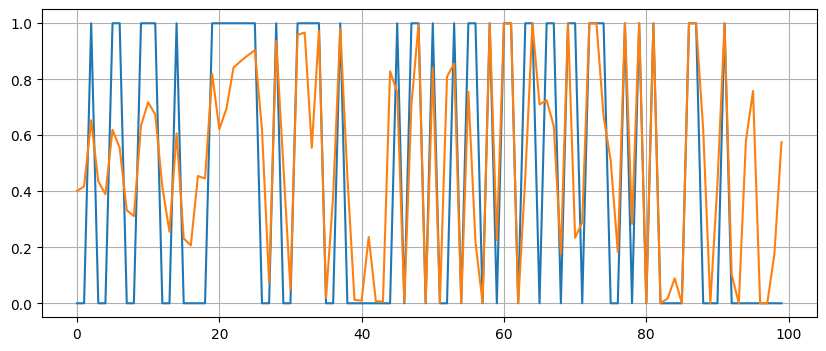

In [5]:
# 状態の予測精度の変化
plt.figure(figsize=(10, 4))
i = 0   # s_i
plt.plot( s[:100, i, 1])
plt.plot(qs[:100, i, 1])
# plt.plot(  s[-100:, i, 1])
# plt.plot( qs[-100:, i, 1])
plt.grid()

# 自動微分による更新

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn

Ns = 2      # number of hidden states
No = 32     # number of observations
T = 5000    # time

In [9]:
class BSS(nn.Module):
    def __init__(self, qa_init: torch.Tensor, alpha: torch.Tensor):
        super().__init__()
        self.qa = nn.Parameter(qa_init.clone()) # (No, 2, Ns, 2)
        self.alpha = alpha   # (Ns, 2)

    def forward(self, o: torch.Tensor): # (T, No, 2)
        o = o.view(-1, No, 2, 1, 1)
        qA = self.qa / self.qa.sum(1, keepdim=True) # (No, 2, Ns, 2)
        v = ((qA.log() * o).sum((1, 2)) + self.alpha).exp()   # (T, Ns, 2)
        qs = v / v.sum(-1, keepdim=True)
        VFE = (qs * (qs / v + 1e-24).log()).sum() / len(o)
        return VFE, qs

In [16]:
seed = 1000000
np.random.seed(seed)
torch.manual_seed(seed)

# Generative Process
A = np.zeros((No, 2, 2, 2)) # A[i,k,l0,l1] = P(o_i=k | s_j=l_j)
A[:No//2, 0] = [[1, 3/4], [1/4, 0]]
A[No//2:, 0] = [[1, 1/4], [3/4, 0]]
A[:, 1, :, :] = 1 - A[:, 0, :, :]
s = np.eye(2, dtype=int)[np.random.randint(0, 2, (T, Ns))]  # (T, Ns, 2)
o = np.eye(2, dtype=int)[(np.random.rand(T*No).reshape((T,No)) > A[:, 0, 1-s[:,0,0], 1-s[:,1,0]].T)*1]    # (T, No, 2)

# Initial Connection Strengths
qa_init = np.array([[[.51,.49],[.5,.5]]]*(No//2) + [[[.5,.5],[.49,.51]]]*(No//2))   # (No, Ns, 2)
qa_init = np.stack([qa_init, 1-qa_init], axis=1) * 100

alpha = np.log(np.array([[0.5, 0.5], [0.5, 0.5]]))  # (Ns, 2)

s = torch.tensor(s)
o = torch.tensor(o)
qa_init = torch.tensor(qa_init)
alpha = torch.tensor(alpha)

In [19]:
model = BSS(qa_init, alpha)
optimizer = torch.optim.SGD(model.parameters(), lr=100) # lr=1

history = []
qs_history = torch.zeros((T, Ns, 2))
for t in range(1, 1+5000):
    optimizer.zero_grad()
    L, qs = model(o[:t][-1000:])
    L.backward()
    optimizer.step()

    history.append(float(L))
    qs_history[t-1] = qs[-1].detach()
    if t % 500 == 0:
        print(f"t = {t} | {L:.4f}")

t = 500 | 35.0654
t = 1000 | 34.7611
t = 1500 | 34.0985
t = 2000 | 34.4996
t = 2500 | 34.5509
t = 3000 | 33.9451
t = 3500 | nan
t = 4000 | nan
t = 4500 | nan
t = 5000 | nan


Text(0, 0.5, 'VFE')

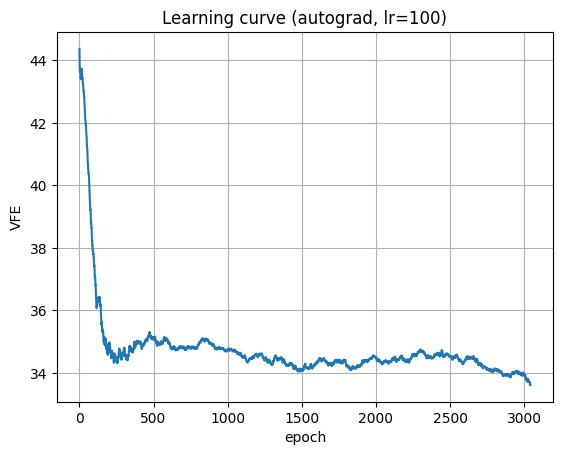

In [36]:
plt.plot(history)
plt.grid()
plt.title(f"Learning curve (autograd, lr={optimizer.param_groups[0]['lr']})")
plt.xlabel("epoch")
plt.ylabel("VFE")

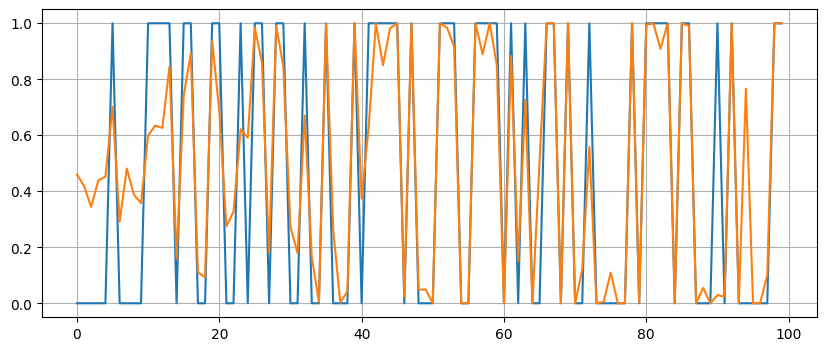

In [21]:
# 状態の予測精度の変化
plt.figure(figsize=(10, 4))
i = 0   # s_i
plt.plot(         s[:100, i, 1])
plt.plot(qs_history[:100, i, 1])
# plt.plot(  s[-100:, i, 1])
# plt.plot( qs[-100:, i, 1])
plt.grid()